In [6]:
# The goal of this nb is to create a ML model to predict the expected loss (for the insurance company) given an individual and their subsequent characteristics such as age, sex, smoking, etc. 

# ExpAmt fields – these values represent the expected claim amounts for the policy year based upon certain mortality tables (such as the 2015 vbt, for example).
    # The values depend upon various factors such as issue age, sex, smoker/non-smoker, and duration.
    # For example, suppose we had a policy issued on a 20-year-old male non-smoker that is now in its 10th policy year (duration = 10, and the insured is now 30 years old).
    # According to the 2015 vbt table, the expected death rate for such a person is 0.44 per 1000; said differently, you could say that such an individual has a 0.44/1000 = 0.00044 probability of dying that year.
    # If the policy were for 500,000, then our expected claim amount for the policy year would be 500,000 * 0.44 / 1000 = 220.
    # As you might expect, older individuals will typically have a higher probability of dying and thus higher expected claim amounts for the same policy size.
    # Similarly, different smoker status and/or sex will affect the expected claim amounts.

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import math
import seaborn as sns

from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy import stats

In [8]:
# Bring in Data and Select Input and Output variable(s)

df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
df3 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2023.csv')

df = pd.concat([df0,df1,df2,df3], axis=0,ignore_index=True,)

df = df.drop_duplicates()

X = df[['CvgSexCode',
        'CvgIssueAge',
        'Duration',
        'AttainedAge',
        'MortExposureAmt',
        'PivotTobaccoCode',
        '2015vbtExpAmt',
        '2015vbtExpNum'
        ]]


C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\836678366.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2020.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\836678366.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2021.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\836678366.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv(r'C:\Users\oakle\Documents\School work\Math\Senior Project\Mort2022.csv')
C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\836678366.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(r'C:\Users\oakle\Documents\School 

In [9]:
X.reset_index(inplace=True,drop=True)

for row in X.itertuples():


    index = row[0]
    
    # Convert sex_char to num
    gender = row.CvgSexCode
    if gender == 'M':
        X.at[index,'CvgSexCode'] = 0
    else: X.at[index,'CvgSexCode'] = 1

    # Convert smoker to num
    smoker = str(getattr(row,'PivotTobaccoCode'))
    if smoker == 'S':
        X.at[index,'PivotTobaccoCode'] = 1
    else: X.at[index,'PivotTobaccoCode'] = 0


In [10]:
X

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
0,0,33,20,52,100000.000000,1,483.000000,0.0032
1,1,53,20,72,5416.666667,0,53.895833,0.0008
2,1,52,20,71,14166.666670,0,125.091667,0.0014
3,0,28,20,47,16500.000000,1,54.450000,0.0008
4,0,52,20,71,8041.666667,1,255.403333,0.0026
...,...,...,...,...,...,...,...,...
3324015,0,45,15,59,100000.000000,0,340.000000,0.0034
3324016,0,26,19,44,100000.000000,0,111.000000,0.0000
3324017,0,26,18,43,250000.000000,0,265.000000,0.0000
3324018,0,36,16,51,350000.000000,1,1456.000000,0.0000


In [11]:

y = df['MortDecAmt']
y

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
3324015    0.0
3324016    0.0
3324017    0.0
3324018    0.0
3324019    0.0
Name: MortDecAmt, Length: 3324020, dtype: float64

In [12]:
# Perform a cube root transformation on 'MortExposureAmt', '2015vbtExpAmt', and '2015vbtExpNum'
X['MortExposureAmt'] = X['MortExposureAmt']**(1/3)
X['2015vbtExpAmt'] = X['2015vbtExpAmt']**(1/3)
X['2015vbtExpNum'] = X['2015vbtExpNum']**(1/3)
y = y**(1/3)

C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\3250471093.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['MortExposureAmt'] = X['MortExposureAmt']**(1/3)
C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\3250471093.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['2015vbtExpAmt'] = X['2015vbtExpAmt']**(1/3)
C:\Users\oakle\AppData\Local\Temp\ipykernel_13304\3250471093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [13]:
# Designate 80% of Data for training the model and 20% for Testing/Validation
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=.8,test_size=.2,random_state=50)

# ------------------- FROM THIS POINT ON ALL TRAIN AND TEST DATA MUST BE SEPARATE. --------------------------------

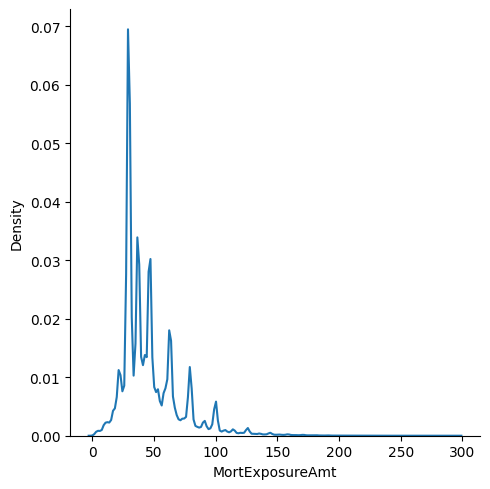

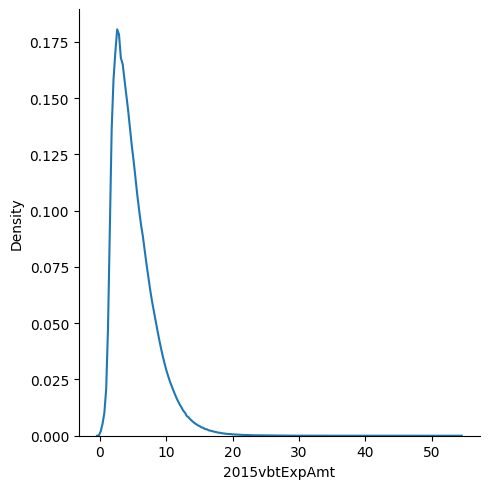

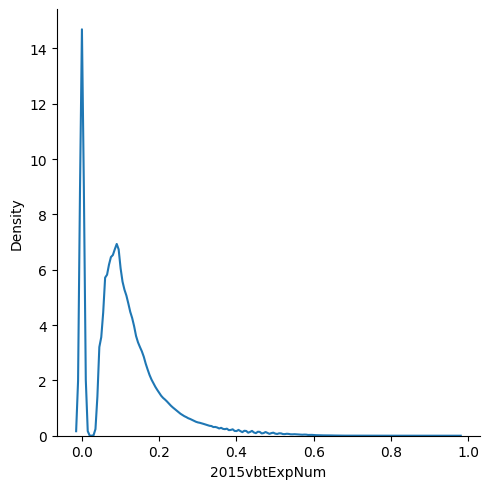

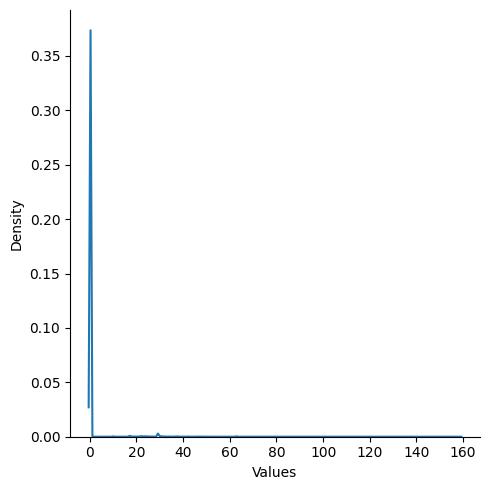

In [14]:
# Handle Outliers of 'MortExposureAmt', '2015vbtExpAmt', and '2015vbtExpNum' for Train and Test individually
# DO NOT MIX TRAIN AND TEST DATA
# MAKE SURE TO TRANSFER ALL TRANSFORMATIONS DONE TO TRAIN ONTO TEST

# Use this link for references: https://neuraldatascience.io/5-eda/data_cleaning.html


# Plot distributions
sns.displot(kind='kde',
           data=X_train,
           x='MortExposureAmt'
           )

sns.displot(kind='kde',
           data=X_train,
           x='2015vbtExpAmt'
           )

sns.displot(kind='kde',
           data=X_train,
           x='2015vbtExpNum'
           )

# Convert y_train to DF
y_temp = pd.DataFrame({'Values': y_train.reset_index(drop=True)})

sns.displot(kind='kde',
           data=y_temp,
           x= 'Values'
           )


plt.show()

#

In [15]:
# #Calculate the range of the outliers
# mea_q1 = X_train['MortExposureAmt'].quantile(0.25)
# mea_q3 = X_train['MortExposureAmt'].quantile(0.75)
# mea_iqr = mea_q3 - mea_q1
# mea_out_low = mea_q1 - 1.5 * mea_iqr
# mea_out_high = mea_q3 + 1.5 * mea_iqr

# vbtAMT_q1 = X_train['2015vbtExpAmt'].quantile(0.25)
# vbtAMT_q3 = X_train['2015vbtExpAmt'].quantile(0.75)
# vbtAMT_iqr = vbtAMT_q3 - vbtAMT_q1
# vbtAMT_out_low = vbtAMT_q1 - 1.5 * vbtAMT_iqr
# vbtAMT_out_high = vbtAMT_q3 + 1.5 * vbtAMT_iqr

# vbtNUM_q1 = X_train['2015vbtExpNum'].quantile(0.25)
# vbtNUM_q3 = X_train['2015vbtExpNum'].quantile(0.75)
# vbtNUM_iqr = vbtNUM_q3 - vbtNUM_q1
# vbtNUM_out_low = vbtNUM_q1 - 1.5 * vbtNUM_iqr
# vbtNUM_out_high = vbtNUM_q3 + 1.5 * vbtNUM_iqr

# y_q1 = y_train.quantile(0.25)
# y_q3 = y_train.quantile(0.75)
# y_iqr = y_q3 - y_q1
# y_out_low = y_q1 - 1.5 * y_iqr
# y_out_high = y_q3 + 1.5 * y_iqr

# # Convert y_train to pd.Dataframe
# y_train = pd.DataFrame(y_train)

# # Add outlier bool collumn for each variable
# X_train['mea_outliers_tukey'] = (X_train.loc[:,'MortExposureAmt'] < mea_out_low) | (X_train.loc[:,'MortExposureAmt'] > mea_out_high)

# X_train['vbtAMT_outliers_tukey'] = (X_train.loc[:,'2015vbtExpAmt'] < vbtAMT_out_low) | (X_train.loc[:,'2015vbtExpAmt'] > vbtAMT_out_high)

# X_train['vbtNUM_outliers_tukey'] = (X_train.loc[:,'2015vbtExpNum'] < vbtNUM_out_low) | (X_train.loc[:,'2015vbtExpNum'] > vbtNUM_out_high)

# y_train['outliers_tukey'] = (y_train < mea_out_low) | (y_train > mea_out_high)

# print(X_train.head)
# print()
# print(y_train.head)

In [16]:
# # Add Z score collumn for each variable that required outlier ellimination

# X_train['MortExposureAmt_Z'] = stats.zscore(X_train['MortExposureAmt'])
# X_train['2015vbtExpAmt_Z'] = stats.zscore(X_train['2015vbtExpAmt'])
# X_train['2015vbtExpNum_Z'] = stats.zscore(X_train['2015vbtExpNum'])

# X_train.head()

In [17]:
# y_train['Z_values'] = stats.zscore(y_train['MortDecAmt'])
# y_train

In [18]:
# # Add Collumn to check for outliers via Z score test
# z_thresh = 2.5

# X_train['MEA_outliers_z'] = np.abs(X_train['MortExposureAmt_Z']) > z_thresh

# X_train['vbtAMT_outliers_z'] = np.abs(X_train['2015vbtExpAmt_Z']) > z_thresh

# X_train['vbtNUM_outliers_z'] = np.abs(X_train['2015vbtExpNum_Z']) > z_thresh

# y_train['outliers_z'] = np.abs(y_train['Z_values']) > z_thresh

In [19]:
# # Plot the ratio of Outlier to non-outliers
# y_train['outliers_z'].value_counts().plot.pie(autopct = "%.2f")

In [20]:
# # Due to the data being human based It was decided that it would be best to leave the outliers in.

# # Remove outlier collumns

# X_train = X_train.drop(columns=['MEA_outliers_z',
#                                 'vbtAMT_outliers_z',
#                                 'vbtNUM_outliers_z',
#                                 'MortExposureAmt_Z',
#                                 '2015vbtExpAmt_Z',
#                                 '2015vbtExpNum_Z',
#                                 'mea_outliers_tukey',
#                                 'vbtAMT_outliers_tukey',
#                                 'vbtNUM_outliers_tukey'
#                                 ])

# y_train = y_train.drop(columns=['outliers_z',
#                                 'Z_values',
#                                 'outliers_tukey'
#                                 ])

# X_train

In [21]:
# Create Multicollinearity Matrix
# If num > .90 , Column x Row are collinear

# Put Y infront of X variables
Xy_collin = pd.concat([y_train , X_train], axis =1)

# Define collin as standard scaler - [See Sklearn docs for more info]
collin = StandardScaler()

# Fit collin
collin_fit = collin.fit(Xy_collin)

# Convert collin fit back to pd.Dataframe
df_collin = pd.DataFrame(collin_fit.transform(Xy_collin))
df_collin.columns = Xy_collin.columns
df_collin.index = Xy_collin.index

corr_m = df_collin.corr(method='pearson')

corr_m_abs = corr_m.abs()
corr_m_upper = corr_m_abs.where(
    np.triu(np.ones(corr_m_abs.shape), k=1).astype(bool))

corr_m_upper

,MortDecAmt,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
MortDecAmt,NaN,0.019935,0.061441,0.080573,0.113877,0.035325,0.000275,0.100856,0.129288
CvgSexCode,NaN,NaN,0.010784,0.021128,0.024967,0.059342,0.107690,0.172313,0.087733
CvgIssueAge,NaN,NaN,NaN,0.268737,0.726964,0.025791,0.042165,0.438114,0.322592
Duration,NaN,NaN,NaN,NaN,0.466053,0.302463,0.080635,0.259985,0.565243
AttainedAge,NaN,NaN,NaN,NaN,NaN,0.191935,0.018754,0.587772,0.699278
MortExposureAmt,NaN,NaN,NaN,NaN,NaN,NaN,0.062809,0.497756,0.162063
PivotTobaccoCode,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051152,0.026131
2015vbtExpAmt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.578709
2015vbtExpNum,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<function matplotlib.pyplot.show(close=None, block=None)>

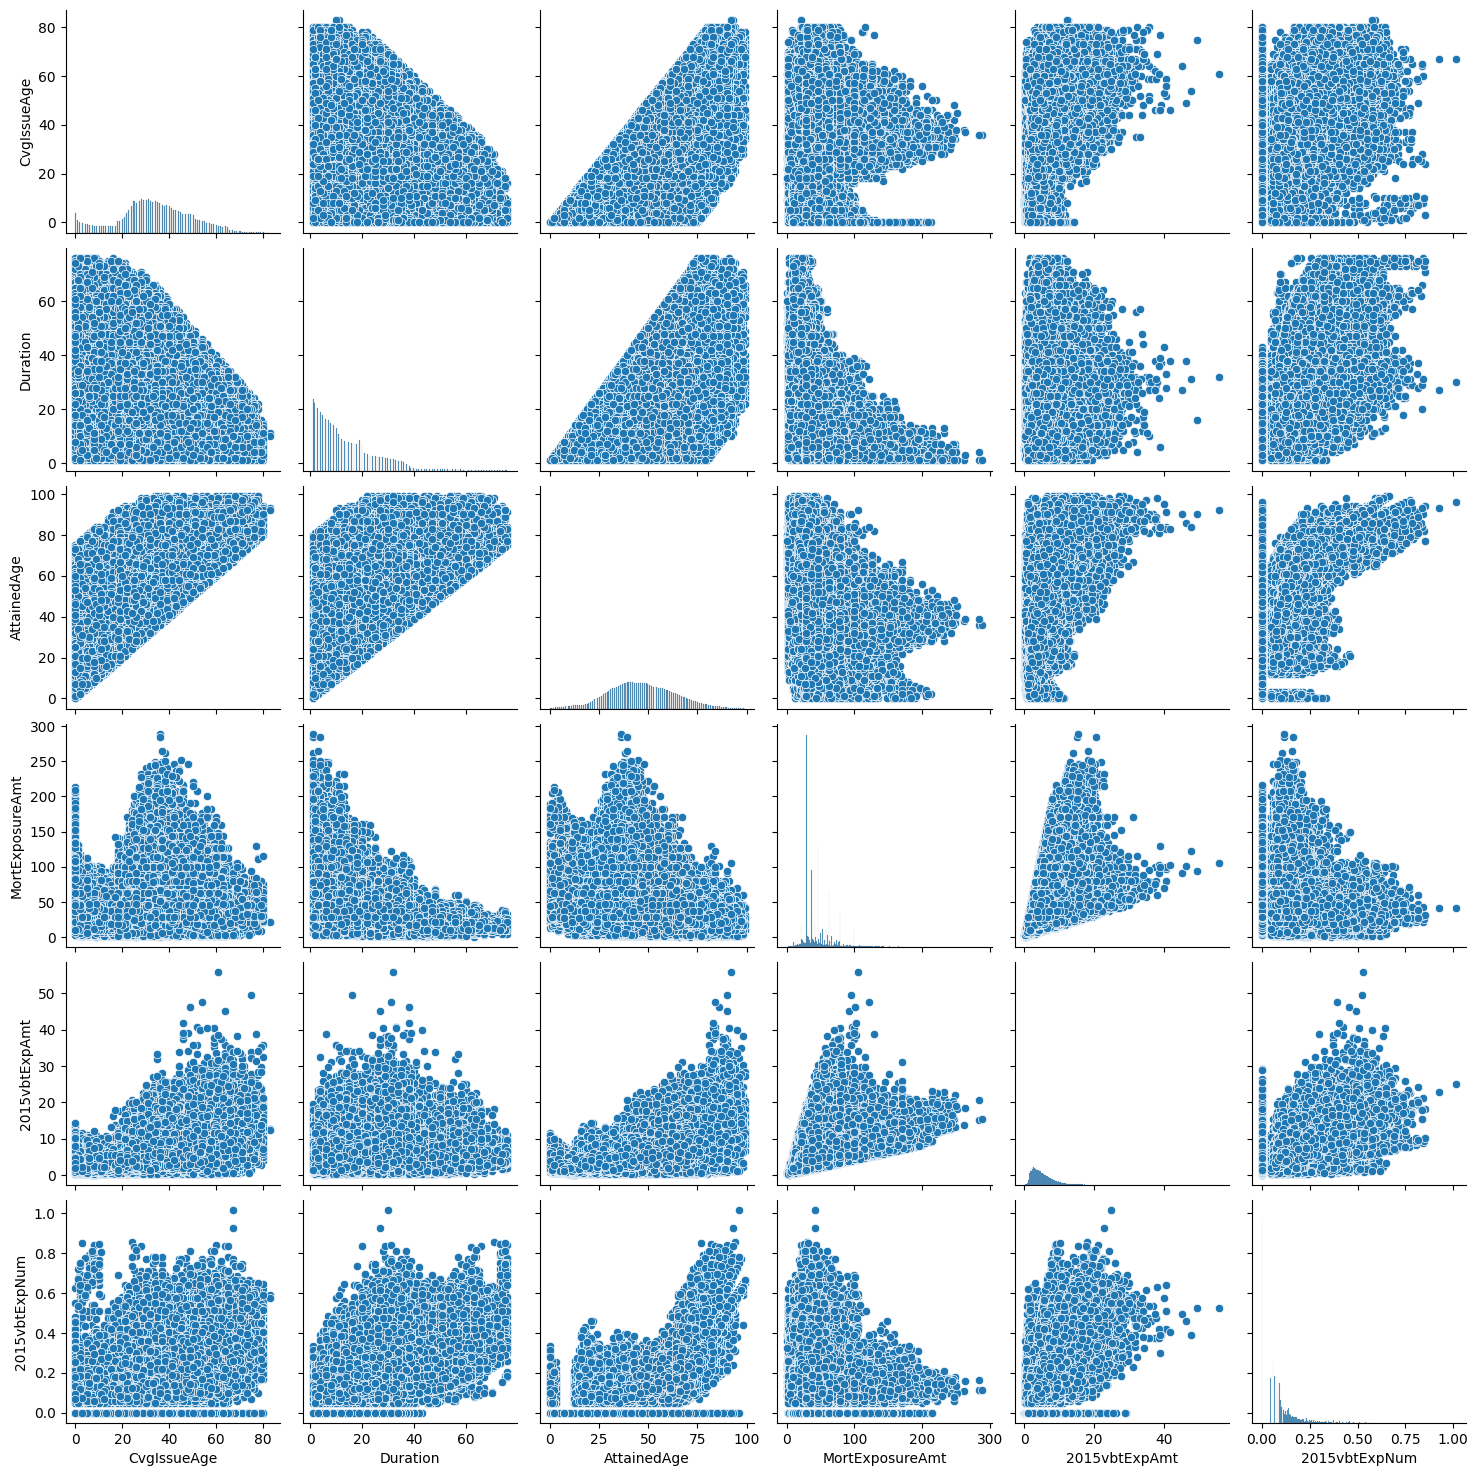

In [22]:
# Create Pairplot to check for weird Data

sns.pairplot(data=(X_test.drop(columns=['CvgSexCode','PivotTobaccoCode'])))
plt.show

In [23]:
# Define the Plot and regress method
def plot_and_measure_regression(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'Predicted')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Expected')
    plt.title(f'{model_name} Regression Chart')
    plt.xlabel('Sorted Index (meaningless)')
    plt.legend()
    plt.ylabel('MortDecAmount')
    plt.show()

# Define the Plot and classify method
def plot_and_measure_classification(model_name :str , y_pred, y_true):

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    y_pred_sorted = np.sort(y_pred, axis=0)
    y_true_sorted = np.sort(y_true, axis=0)

    plt.figure
    plt.plot(y_pred_sorted, color = 'Blue', label = 'Predicted')
    plt.plot(y_true_sorted, color = 'Orange', label = 'Expected')
    plt.title(f'{model_name} Regression Chart')
    plt.xlabel('Sorted Index (meaningless)')
    plt.legend()
    plt.ylabel('MortDecAmount')
    plt.show()

# Define Expected vs Predicted graph function
def exp_vs_pred(model_name :str, y_pred, y_true):

    plt.scatter(x= y_true, y= y_pred, color = 'Blue')
    plt.axline(xy1=(0,0), slope= 1, color = 'Orange',label = 'Ideal Line')
    plt.title(f'{model_name} Expected vs Predicted')
    plt.legend()
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.show()



HGBT R2 Score = 9.80440376167166
HGBT MSE Score = 0.03757663857285054


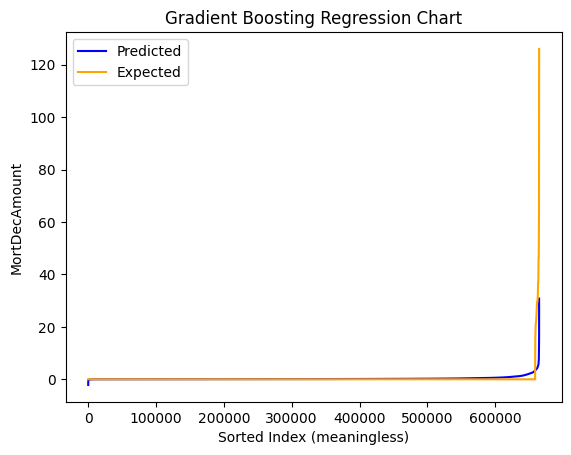

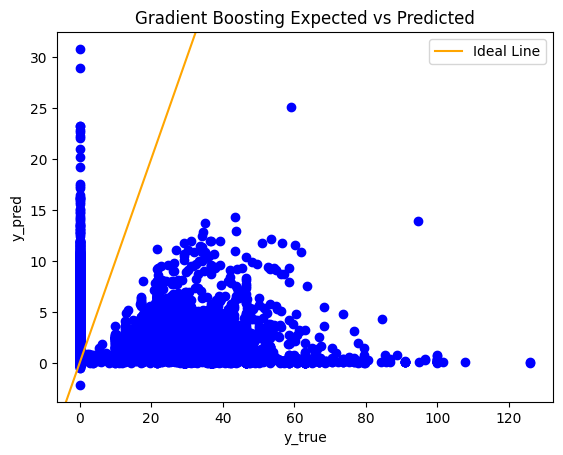

In [24]:
# ----------------------  Test 1 - Histogram Gradient Boosted Trees ------------------------------------

# Define model and train using Train data only
HBGT_model = HistGradientBoostingRegressor(loss ='squared_error')

HBGT_model.fit(X_train,y_train)

# Use trained model to predict Y for validation
HGBT_y_pred = HBGT_model.predict(X_test)

# Evaluate Model using R^2 and MSE
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

HGBT_r2 = mean_squared_error(y_true= y_test, y_pred=HGBT_y_pred)
HGBT_MSE = r2_score(y_true= y_test, y_pred=HGBT_y_pred)

print(f'HGBT R2 Score = {HGBT_r2}')
print(f'HGBT MSE Score = {HGBT_MSE}')

plot_and_measure_regression(model_name='Gradient Boosting',
                            y_pred= HGBT_y_pred,
                            y_true= y_test
                               )

exp_vs_pred(model_name= 'Gradient Boosting',
            y_pred= HGBT_y_pred,
            y_true= y_test
            )

In [25]:
# # -----------------------  Test 2 - MLP Regressor (Neural Network)  -----------------------------

# NN_model = MLPRegressor(solver='adam',early_stopping=True)

# NN_model.fit(X_train,y_train)

# NN_y_pred = NN_model.predict(X_test)

# NN_r2 = mean_squared_error(y_true= y_test, y_pred=NN_y_pred)
# NN_MSE = r2_score(y_true= y_test, y_pred=NN_y_pred)

# print(f'NN R2 Score = {NN_r2}')
# print(f'NN MSE Score = {NN_MSE}')

# plot_and_measure_regression(model_name='Neural Network', 
#                             y_pred=NN_y_pred,
#                             y_true=y_test
#                             )

# exp_vs_pred(model_name='Neural Network',
#             y_pred=NN_y_pred,
#             y_true=y_test
#             )

In [26]:
# # ----------------------------------  Test 3 - Random Forest Regression  -------------------------------------

# RFR_model = RandomForestRegressor()

# RFR_model.fit(X_train,y_train)

# RFR_y_pred = RFR_model.predict(X_test)

# RFR_r2 = mean_squared_error(y_true= y_test, y_pred=RFR_y_pred)
# RFR_MSE = r2_score(y_true= y_test, y_pred=RFR_y_pred)

# print(f'NN R2 Score = {RFR_r2}')
# print(f'NN MSE Score = {RFR_MSE}')

# plot_and_measure_regression(model_name='Random Forest', 
#                             y_pred=RFR_y_pred,
#                             y_true=y_test
#                             )

# exp_vs_pred(model_name='Random Forest',
#             y_pred=RFR_y_pred,
#             y_true=y_test
#             )


In [27]:
# Notes:

# It was discovered that a simple regression algorithm will likley not suffice to accurately predict the final amount to be paid. 

# Hypothetical solution: 
# Create a two part model with one part to classify each row as either a 0 or non-0. 
# Then using the non-0 entries create a model that predicts the non-0 values



# Next steps:
# Create a binary classification model (Likely logistic regression) to predict if any amount will be paid out. 
# Create a linear regression model (Likely Grad. Boosting)
# Combine the two models to accurately predict the payout amount of any given customer.

In [28]:
# Create boolean collumn in data that designates either 0 or non-0 payout amount
y = df['MortDecAmt']
y = pd.DataFrame(y)

is_zero = []

for row in range(y.shape[0]):
    if y['MortDecAmt'][row] == 0:
        is_zero.append(1)
    else:
        is_zero.append(0)

y.insert(loc=1,column='is_zero',value=is_zero)
y

,MortDecAmt,is_zero
0,0.0,1
1,0.0,1
2,0.0,1
3,0.0,1
4,0.0,1
...,...,...
3324015,0.0,1
3324016,0.0,1
3324017,0.0,1
3324018,0.0,1


In [29]:
X

,CvgSexCode,CvgIssueAge,Duration,AttainedAge,MortExposureAmt,PivotTobaccoCode,2015vbtExpAmt,2015vbtExpNum
0,0,33,20,52,46.415888,1,7.846013,0.147361
1,1,53,20,72,17.562137,0,3.777331,0.092832
2,1,52,20,71,24.196686,0,5.001222,0.111869
3,0,28,20,47,25.458217,1,3.790233,0.092832
4,0,52,20,71,20.034662,1,6.344667,0.137507
...,...,...,...,...,...,...,...,...
3324015,0,45,15,59,46.415888,0,6.979532,0.150369
3324016,0,26,19,44,46.415888,0,4.805896,0.000000
3324017,0,26,18,43,62.996052,0,6.423158,0.000000
3324018,0,36,16,51,70.472987,1,11.334102,0.000000


In [30]:
# Import a few Classification model options
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Split X and Y into Train and Test
X_train, X_test, y_train, y_test = train_test_split( X, y, train_size=.8, test_size=.2, random_state=50)

LR_accuracy = 0.9911477668606086
LR_F1_score = 0.9955542058270499
0
1    664804
Name: count, dtype: int64
is_zero
1    658919
0      5885
Name: count, dtype: int64


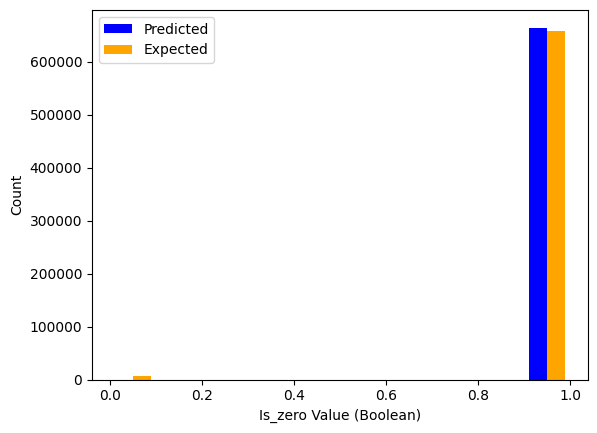

In [54]:
# ----------------------------- Part 1: Create logistic classification model ------------------------------
from sklearn.metrics import accuracy_score , f1_score

LR_model = LogisticRegression()

LR_model.fit(X=X_train, y= y_train['is_zero'])

LR_y_pred = LR_model.predict(X_test)
LR_y_pred = pd.DataFrame(LR_y_pred)


LR_accuracy = accuracy_score(y_true= y_test['is_zero'], y_pred= LR_y_pred.values)
LR_F1_score = f1_score(y_true= y_test['is_zero'], y_pred= LR_y_pred.values)

print(f'LR_accuracy = {LR_accuracy}')
print(f'LR_F1_score = {LR_F1_score}')


plt.figure()
plt.hist(x=[LR_y_pred[0],y_test['is_zero']],color=['Blue','Orange'],label=['Predicted','Expected'])
plt.legend()
plt.xlabel('Is_zero Value (Boolean)')
plt.ylabel('Count')
plt.show

pred_num_zeros = LR_y_pred.value_counts()
print(pred_num_zeros)

test_num_zeros = y_test['is_zero'].value_counts()
print(test_num_zeros)